In [16]:
import sys, os
BIN = os.path.expanduser("../../../")
sys.path.append(BIN)

In [17]:
import numpy as np
from scipy.constants import m_p, c, e
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.simple_long_tracking import LinearMap
import PyHEADTAIL.particles.generators as generators
import PyHEADTAIL.cobra_functions.stats as st


In [29]:
def test_transverse_map(n_macroparticles, linear_map, gamma = 3730.27):
    ax = np.array([1, 2, 3])
    ay = [1, 2, 3]
    bx = [1, 2, 3]
    by = [1, 0.5, 0.5]
    dx = np.array([0.5, 5000, 0.3])
    dy = np.array([0.2, -10000, 2])
    segments = np.linspace(0., C, num=4)
    
    # generate a map with the given parameters
    trans_map = TransverseMap(C, segments, ax, bx, dx, ay, by, dy, Q_x, Q_y)
    map_ = [m for m in trans_map]
    
    # generate a bunch matched to the alpha, beta and d of the first segment
    b = generate_bunch(n_macroparticles, ax[0], ay[0], bx[0], by[0], linear_map, dx[0], dy[0], gamma)
    
    def print_parameters(b, it):
        it = it % 3 #to make sure that after the last segment you access the first segment's parameters
        print('alphax: ' + str(ax[it]) + ' <---> ' + str(b.alpha_Twiss_x()))
        print('alphay: ' + str(ay[it]) + ' <---> ' + str(b.alpha_Twiss_y()))
        print('betax: ' + str(bx[it]) + ' <---> ' + str(b.beta_Twiss_x()))
        print('betay: ' + str(by[it]) + ' <---> ' + str(b.beta_Twiss_y()))
        print('dispx: ' + str(dx[it]) + ' <---> ' + str(b.dispersion_x()))
        print('dispy: ' + str(dy[it]) + ' <---> ' + str(b.dispersion_y()))
        print('epsnx: ' + str(3.75e-6) + ' <---> ' + str(b.epsn_x()))
        print('epsny: ' + str(3.75e-6) + ' <---> ' + str(b.epsn_y()))
        print('epsnz: ' + 'TODO' + ' <---> ' + str(b.epsn_z()))
        print('\n')
    
    print_parameters(b, 0) # matched to the first segment
    #track and check parameters!
    nturns = 3
    for n in xrange(nturns):
        for it,m in enumerate(map_):
            m.track(b)
            print_parameters(b, it+1)
    #check after the last segment           

            
    

In [19]:
def generate_bunch(n_macroparticles, alpha_x, alpha_y, beta_x, beta_y, linear_map, dispx, dispy, gamma = 3730.27):
    # generate a alpha=0, beta=1 bunch first
    # then transform...
    intensity = 1.05e11
    sigma_z = 0.59958
    gamma_t = 1. / np.sqrt(alpha_0)
    p0 = np.sqrt(gamma**2 - 1) * m_p * c

    beta_z = (linear_map.eta(dp=0, gamma=gamma) * linear_map.circumference / 
              (2 * np.pi * linear_map.Qs))

    epsn_x = 3.75e-6 # [m rad]
    epsn_y = 3.75e-6 # [m rad]
    epsn_z = 4 * np.pi * sigma_z**2 * p0 / (beta_z * e)
    
    bunch = generators.Gaussian6DTwiss(
        macroparticlenumber=n_macroparticles, intensity=intensity, charge=e,
        gamma_reference=gamma, mass=m_p, circumference=C,
        alpha_x=0., beta_x=1., epsn_x=epsn_x,
        alpha_y=0., beta_y=1., epsn_y=epsn_y,
        beta_z=beta_z, epsn_z=epsn_z).generate()
    
    # Scale to correct beta and alpha
    bunch.x *= np.sqrt(beta_x)
    bunch.xp = -alpha_x/np.sqrt(beta_x) * bunch.x + 1./np.sqrt(beta_x) * bunch.xp
    
    bunch.y = np.sqrt(beta_y)*bunch.y
    bunch.yp = -alpha_y/np.sqrt(beta_y) * bunch.y + 1./np.sqrt(beta_y) * bunch.yp
    
    
    
    bunch.x += dispx * bunch.dp
    bunch.y += dispy * bunch.dp
    
    return bunch

In [20]:
def plot_phase_space(beam, direction):
    plt.figure()
    u = getattr(beam, direction[0])
    up = getattr(beam, direction[1])
    plt.scatter(u, up)
    minimum = min(min(u),min(up))
    maximum =  max(max(u), max(up))
    plt.ylim([minimum, maximum])
    plt.xlim([minimum, maximum])
    plt.xlabel(direction[0])
    plt.ylabel(direction[1])
    plt.show()

In [21]:
# Generate a bunch with the given optics and compare them to the statistically computed parameters
def compute_statistical_beam_optics(alphax, alphay, betax, betay, long_map, dispx, dispy, gamma=3000):
    b = generate_bunch(n_macroparticles, alphax, alphay, betax, betay, long_map, dispx, dispy, gamma)
    print('Compare the nominal and the statistically computed quantities from the beam')
    print('nominal: <---> statistical:')
    print('alphax: ' + str(alphax) + ' <---> ' + str(b.alpha_Twiss_x()))
    print('alphay: ' + str(alphay) + ' <---> ' + str(b.alpha_Twiss_y()))
    print('betax: ' + str(betax) + ' <---> ' + str(b.beta_Twiss_x()))
    print('betay: ' + str(betay) + ' <---> ' + str(b.beta_Twiss_y()))
    print('dispx: ' + str(dispx) + ' <---> ' + str(b.dispersion_x()))
    print('dispy: ' + str(dispy) + ' <---> ' + str(b.dispersion_y()))
    

In [22]:
def plot_histogram(measurements, exact_value, title="Dummy"):
    plt.hist(measurements)
    plt.axvline(measurements.mean(), color='r', linestyle='dashed', linewidth=2)
    plt.axvline(exact_value, color='g', linewidth=2)
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('# observations')
    m = mpatches.Patch(color='red', label='mean')
    ex = mpatches.Patch(color='green', label='input')

    plt.legend(handles=[m, ex])
    plt.show()


In [23]:
def compute_distribution_beam_optics(alphax, alphay, betax, betay, long_map, dispx, dispy, gamma=3000):
    nsamples = 100
    stat_betax = np.zeros(nsamples)
    stat_betay = np.zeros(nsamples)
    stat_alphax = np.zeros(nsamples)
    stat_alphay = np.zeros(nsamples)
    stat_dispx = np.zeros(nsamples)
    stat_dispy = np.zeros(nsamples)
    for i in xrange(nsamples):
        b = generate_bunch(n_macroparticles, alphax, alphay, betax, betay, long_map, dispx, dispy,gamma)
        stat_betax[i] = b.beta_Twiss_x()
        stat_betay[i] = b.beta_Twiss_y()
        stat_dispx[i] = b.dispersion_x()
        stat_dispy[i] = b.dispersion_y()
        stat_alphax[i] = b.alpha_Twiss_x()
        stat_alphay[i] = b.alpha_Twiss_y()
    plot_histogram(stat_betax, betax, 'beta_x')
    plot_histogram(stat_betay, betay, 'beta_y')
    plot_histogram(stat_alphax, alphax, 'alpha_x')
    plot_histogram(stat_alphay, alphay, 'alpha_y')
    plot_histogram(stat_dispx, dispx, 'disp_x')
    plot_histogram(stat_dispy, dispy, 'disp_y')

    plt.show()


In [24]:
# Basic simulation parameters
n_turns = 10
n_segments = 2
n_macroparticles = 100000

Q_x = 64.28
Q_y = 59.31
Q_s = 0.0020443

C = 26658.883
R = C / (2.*np.pi)

alpha_0 = [0.0003225]
long_map = LinearMap(alpha_0, C, Q_s)

Compare the nominal and the statistically computed quantities from the beam
nominal: <---> statistical:
alphax: 1.5 <---> 1.77237339126
alphay: -2 <---> -2.00993846801
betax: 1.4 <---> 1.39942993278
betay: 1 <---> 1.00474634303
dispx: 100 <---> 96.727424136
dispy: 20 <---> 15.3543742521


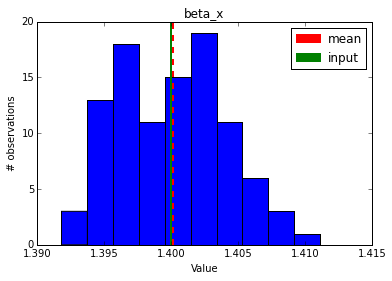

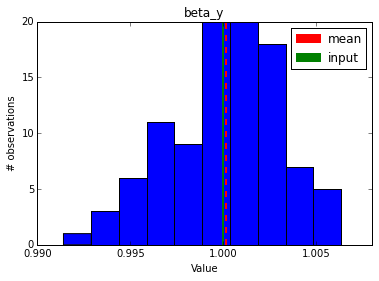

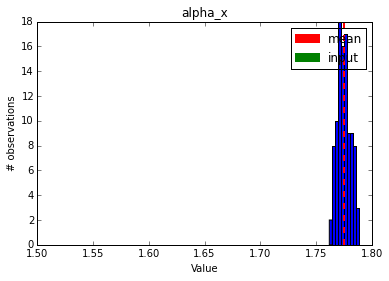

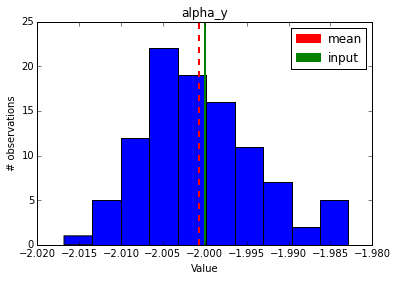

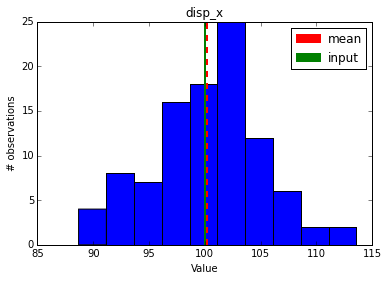

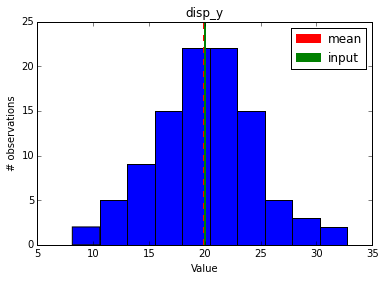

In [25]:
%matplotlib inline
alphax = 1.5
alphay = -2
betax = 1.4
betay = 1
dispx = 100
dispy = 20
beam2 = generate_bunch(n_macroparticles, alphax, alphay, betax, betay, long_map, dispx, dispy, gamma = 2)
compute_statistical_beam_optics(alphax, alphay, betax, betay, long_map, dispx, dispy, gamma=2)

compute_distribution_beam_optics(alphax, alphay, betax, betay, long_map, dispx, dispy, gamma=2)

In [26]:
st.dispersion(beam2.yp, beam2.dp)
#st.mean(np.multiply(beam2.xp, beam2.dp))

-8.479019638146074

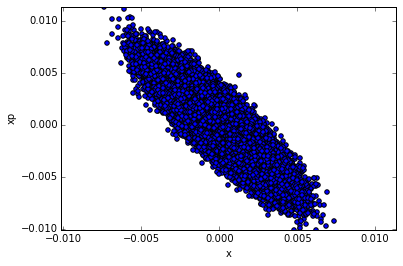

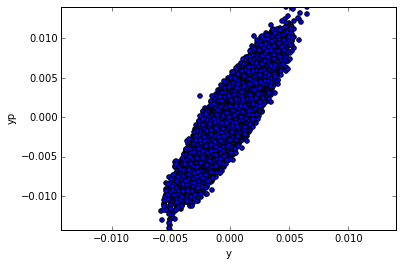

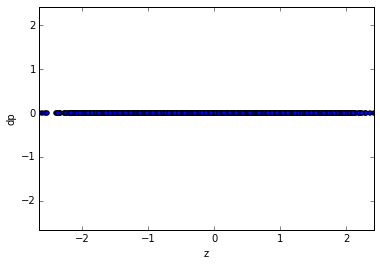

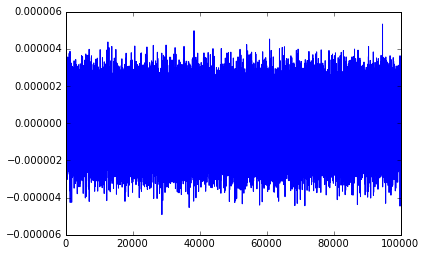

In [27]:
%matplotlib inline
plot_phase_space(beam2, ['x', 'xp'])
plot_phase_space(beam2, ['y', 'yp'])
plot_phase_space(beam2, ['z', 'dp'])
plt.plot(beam2.dp)
plt.show()

In [30]:
test_transverse_map(50000, long_map, 3)


*** PyHEADTAIL WARNING! Non-zero dispersion; ensure the beam has been "blown-up" accordingly upon creation!
alphax: 1 <---> 1.01053469279
alphay: 1 <---> 0.995346357048
betax: 1 <---> 1.00281165497
betay: 1 <---> 0.9993534643
dispx: 0.5 <---> 2.8004334377
dispy: 0.2 <---> -0.562567388436
epsnx: 3.75e-06 <---> 3.77586159072e-06
epsny: 3.75e-06 <---> 3.77243782567e-06
epsnz: TODO <---> 0.000172215232787


alphax: 2 <---> 2.01962351496
alphay: 2 <---> 2.02027878392
betax: 2 <---> 2.01666637011
betay: 0.5 <---> 0.502131549013
dispx: 5000.0 <---> 4996.45326535
dispy: -10000.0 <---> -10001.1202328
epsnx: 3.75e-06 <---> 3.77329985124e-06
epsny: 3.75e-06 <---> 3.7390188502e-06
epsnz: TODO <---> 0.000172215232787


alphax: 3 <---> 3.01542298306
alphay: 3 <---> 3.00026753925
betax: 3 <---> 3.02017550579
betay: 0.5 <---> 0.500682468145
dispx: 0.3 <---> 4.0971986296
dispy: 2.0 <---> 2.25841177375
epsnx: 3.75e-06 <---> 3.77586157607e-06
epsny: 3.75e-06 <---> 3.77243859248e-06
epsnz: TODO <---> 0.0